<a href="https://colab.research.google.com/github/magicmanju/Spam-Detector/blob/main/Spam_Detection_Using_Machine_Learning_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing datasets


In [ ]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Advanced_ML_DL_spam_classification_L4/spam.csv

--2023-05-05 06:29:04--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Advanced_ML_DL_spam_classification_L4/spam.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  1.42MB/s    in 0.3s    

2023-05-05 06:29:05 (1.42 MB/s) - ‘spam.csv’ saved [503663/503663]



##Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import nltk, re, collections, pickle, os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional,GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings(action = "ignore")
warnings.simplefilter(action = 'ignore', category = Warning)
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
pd.set_option("display.precision", 3)
pd.options.display.float_format = '{:.3f}'.format

## Reading the Dataset


In [ ]:
df = pd.read_csv('spam.csv', encoding = 'latin-1')

## Dataset manipulations & EDA


In [ ]:
df = df.filter(['v1', 'v2'], axis = 1)
df.columns = ['feature', 'message']
df.drop_duplicates(inplace = True, ignore_index = True)
print('Number of null values:\n')
df.isnull().sum()

Number of null values:



feature    0
message    0
dtype: int64

In [ ]:
df['feature'].value_counts()

ham     4516
spam     653
Name: feature, dtype: int64

## Describing datasets


In [ ]:
df.describe().T

,count,unique,top,freq
feature,5169,2,ham,4516
message,5169,5169,"Go until jurong point, crazy.. Available only ...",1


## Dataset statistics


##word cloud

In [ ]:
def word_cloud(tag):
  df_words_nl = ' '.join(list(df[df['feature'] == tag]['message']))
  df_len = WordCloud(width = 1000, height = 400).generate(df_words_nl)
  plt.figure(figsize = (10, 8), facecolor = 'black')
  plt.imshow(df_len)
  plt.axis('off')
  plt.tight_layout(pad = 1)
  plt.show()

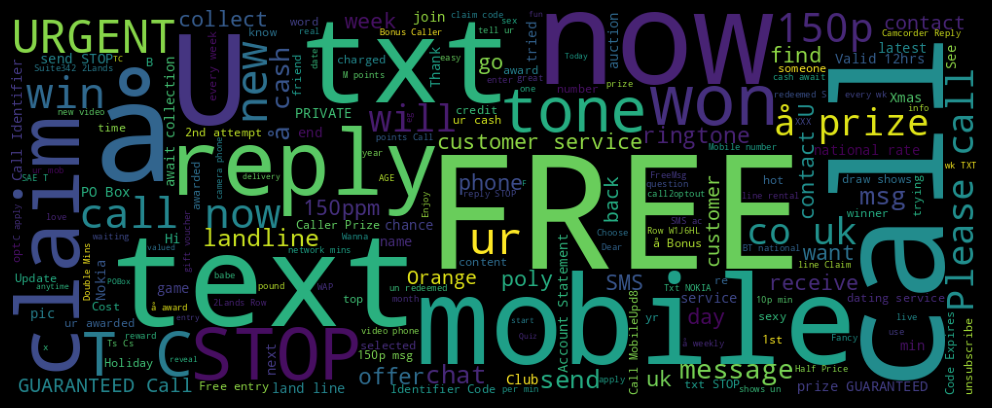

In [ ]:
word_cloud('spam')

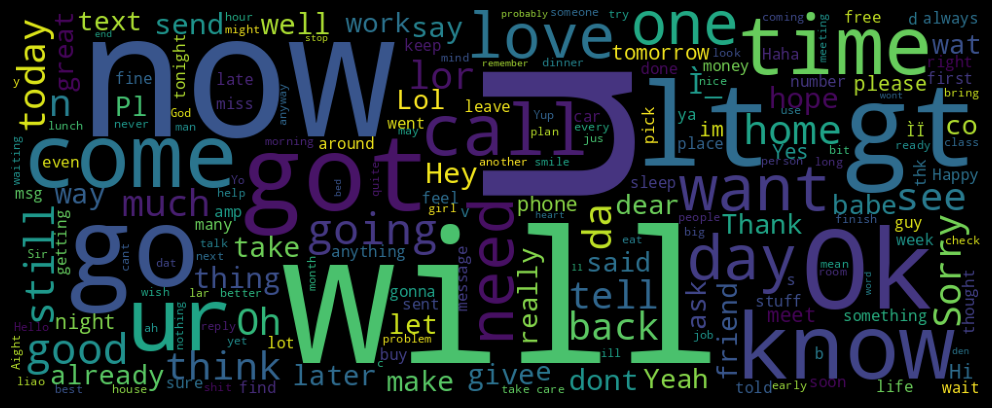

In [ ]:
word_cloud('ham')

##words plotting

In [ ]:
def words_plot(set, number):
  words_counter = collections.Counter([word for sentence in set for word in sentence.split()])
  most_counted = words_counter.most_common(number)
  most_count = pd.DataFrame(most_counted, columns = ["Words", "Amount"]).sort_values(by = "Amount",)
  most_count.plot.barh(x = "Words",
                       y = "Amount",
                       color = "orange",
                       figsize = (6, 5))
  for i, v in enumerate(most_count["Amount"]):
    plt.text(v, i,
             " " + str(v),
             color = 'black',
             va = 'center',
             fontweight = 'bold')

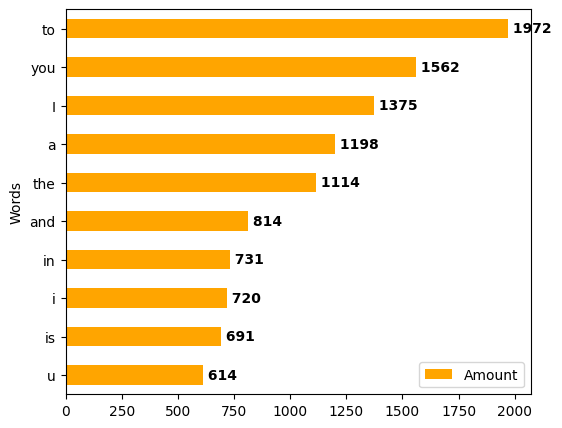

In [ ]:
words_plot(df['message'], number = 10)

##figure plotting

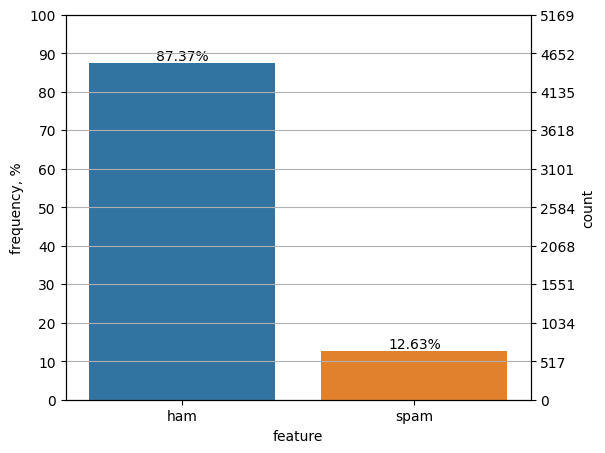

In [ ]:
plt.figure(figsize = (6, 5))
counter = df.shape[0]
ax1 = sns.countplot(x='feature',data = df)
ax2 = ax1.twinx()
ax2.yaxis.tick_left()
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('frequency, %')
for p in ax1.patches:
  x = p.get_bbox().get_points()[:, 0]
  y = p.get_bbox().get_points()[1, 1]
  ax1.annotate('{:.2f}%'.format(100. * y / counter),
              (x.mean(), y),
              ha = 'center',
              va = 'bottom')
ax1.yaxis.set_major_locator(ticker.LinearLocator(11))
ax2.set_ylim(0, 100)
ax1.set_ylim(0, counter)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.grid(None)

##  Machine Learning for SPAM **classification** task




In [ ]:
vocab_size = 1000
embed_dim = 64
oov_token = "<OOV>"
test_size, valid_size = 0.05, 0.2
num_epochs = 20
drop_level = 0.363
trunc_type = 'post'
padding_type = 'post'
threshold = 0.5
seed = 42

##Text Preprocessing

In [ ]:
print("Text Preprocessing\n")
preprocessed_df = []
lemmatizer = WordNetLemmatizer()
for i in range(df.shape[0]):
    message = df.iloc[i, 1]
    message = re.sub('\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', message)
    message = re.sub('(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr', message)
    message = re.sub('£|\$', 'moneysymb', message)
    message = re.sub('\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'phonenumbr', message)
    message = re.sub('\d+(\.\d+)?', 'numbr', message)
    message = re.sub('[^\w\d\s]', ' ', message)
    message = re.sub('[^A-Za-z]', ' ', message).lower()
    token_messages = word_tokenize(message)
    mess = []
    for word in token_messages:
        if word not in set(stopwords.words('english')):
            mess.append(lemmatizer.lemmatize(word))
    txt_mess = " ".join(mess)
    preprocessed_df.append(txt_mess)

Text Preprocessing



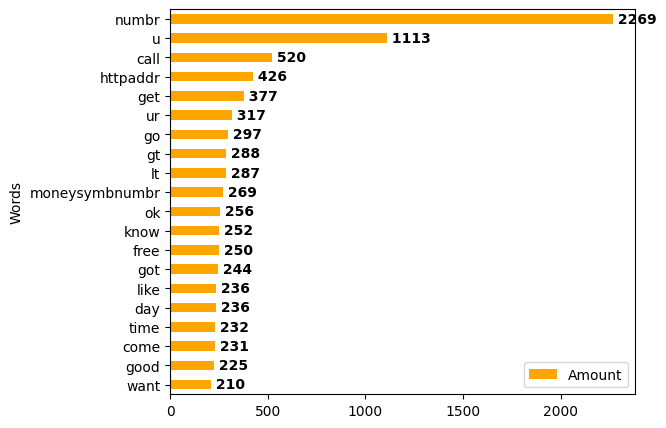

In [ ]:
words_plot(preprocessed_df, number = 20)

##vectorization

In [ ]:
cv = CountVectorizer(max_features = vocab_size)
X = cv.fit_transform(preprocessed_df).toarray()
y = df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (test_size + valid_size), random_state = seed)
print('Number of rows in test set: ' + str(X_test.shape))
print('Number of rows in training set: ' + str(X_train.shape))

Number of rows in test set: (1293, 1000)
Number of rows in training set: (3876, 1000)


In [ ]:
vectorizer = TfidfVectorizer()
tfidf=vectorizer.fit_transform(preprocessed_df)
tfidf_data=pd.DataFrame(tfidf.toarray())
tfidf_data

,0,1,2,3,4,5,6,7,8,9,...,7125,7126,7127,7128,7129,7130,7131,7132,7133,7134
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5164,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5165,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5166,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5167,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


##dumping vectorizer using pickle

In [ ]:
import pickle
pickle.dump(vectorizer,open('vectorizer.pkl','wb'))

##Implementing using the Machine Learning models

---



In [ ]:
def plot_conf_matr(conf_matr, classes,normalize = False,title = 'Confusion matrix', cmap = plt.cm.winter):
  """
  Citation
  ---------
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

  """
  import itertools

  accuracy = np.trace(conf_matr) / np.sum(conf_matr).astype('float')
  sns.set(font_scale = 1.4)

  plt.figure(figsize = (10, 8))
  plt.imshow(conf_matr, interpolation = 'nearest', cmap = cmap)
  title = '\n' + title + '\n'
  plt.title(title)
  plt.colorbar()

  if classes is not None:
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation = 45)
      plt.yticks(tick_marks, classes)

  if normalize:
      conf_matr = conf_matr.astype('float') / conf_matr.sum(axis = 1)[:, np.newaxis]


  thresh = conf_matr.max() / 1.5 if normalize else conf_matr.max() / 2
  for i, j in itertools.product(range(conf_matr.shape[0]), range(conf_matr.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.2f}%".format(conf_matr[i, j] * 100),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(conf_matr[i, j]),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\n\nAccuracy = {:0.2f}%; Error = {:0.2f}%'.format(accuracy * 100, (1 - accuracy) * 100))
  plt.show()

##Multinomial Naive Bayes



In [ ]:
print("\t\t Multinomial Naive Bayes\n")
class_MNB = MultinomialNB().fit(X_train, y_train)
y_pred_MNB = class_MNB.predict(X_test)
print('The first two predicted labels:', y_pred_MNB[0],y_pred_MNB[1], '\n')
conf_m_MNB = confusion_matrix(y_test, y_pred_MNB)
class_rep_MNB = classification_report(y_test, y_pred_MNB)
print('\t\t\tClassification report:\n\n', class_rep_MNB, '\n')
plot_conf_matr(conf_m_MNB, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Multinomial Naive Bayes')

###  Decision Tree Classifier.


		Stage III. Decision Tree Classifier

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.97      0.98      0.98      1107
        spam       0.87      0.84      0.86       186

    accuracy                           0.96      1293
   macro avg       0.92      0.91      0.92      1293
weighted avg       0.96      0.96      0.96      1293
 



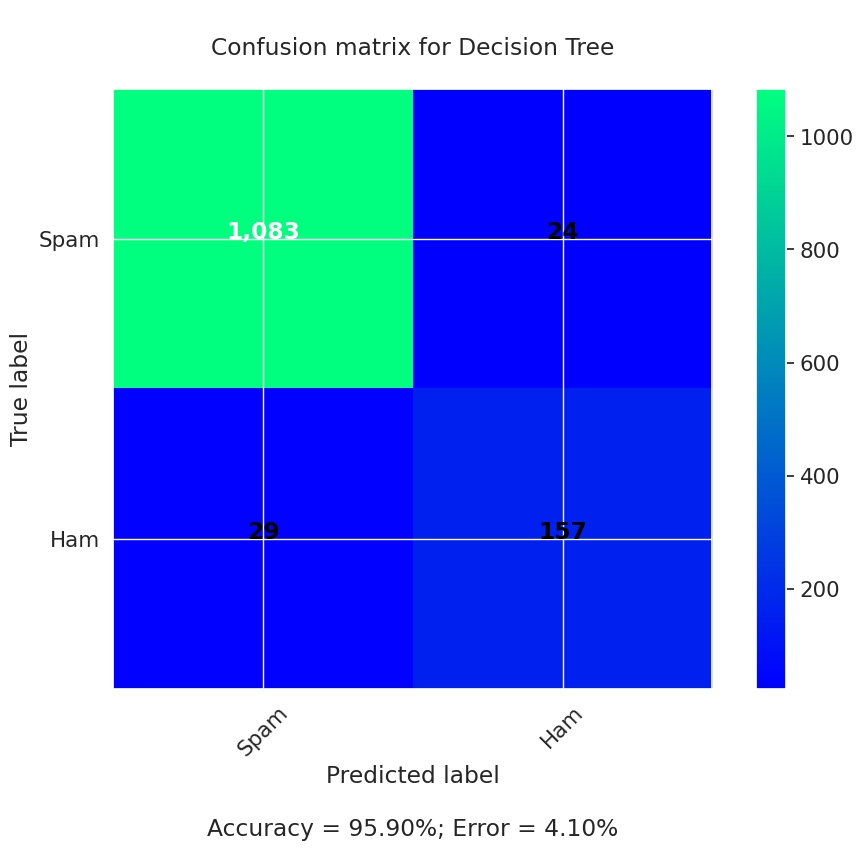

In [ ]:
print("\t\tStage III. Decision Tree Classifier\n")
class_DTC = DecisionTreeClassifier(random_state = seed).fit(X_train, y_train)
y_pred_DTC = class_DTC.predict(X_test)
print('The first two predicted labels:', y_pred_DTC[0], y_pred_DTC[1], '\n')
conf_m_DTC = confusion_matrix(y_test, y_pred_DTC)
class_rep_DTC = classification_report(y_test, y_pred_DTC)
print('\t\t\tClassification report:\n\n', class_rep_DTC, '\n')
plot_conf_matr(conf_m_DTC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Decision Tree')

###Logistic Regression.


		Stage IV. Logistic Regression

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1107
        spam       0.97      0.86      0.91       186

    accuracy                           0.98      1293
   macro avg       0.97      0.93      0.95      1293
weighted avg       0.98      0.98      0.98      1293
 



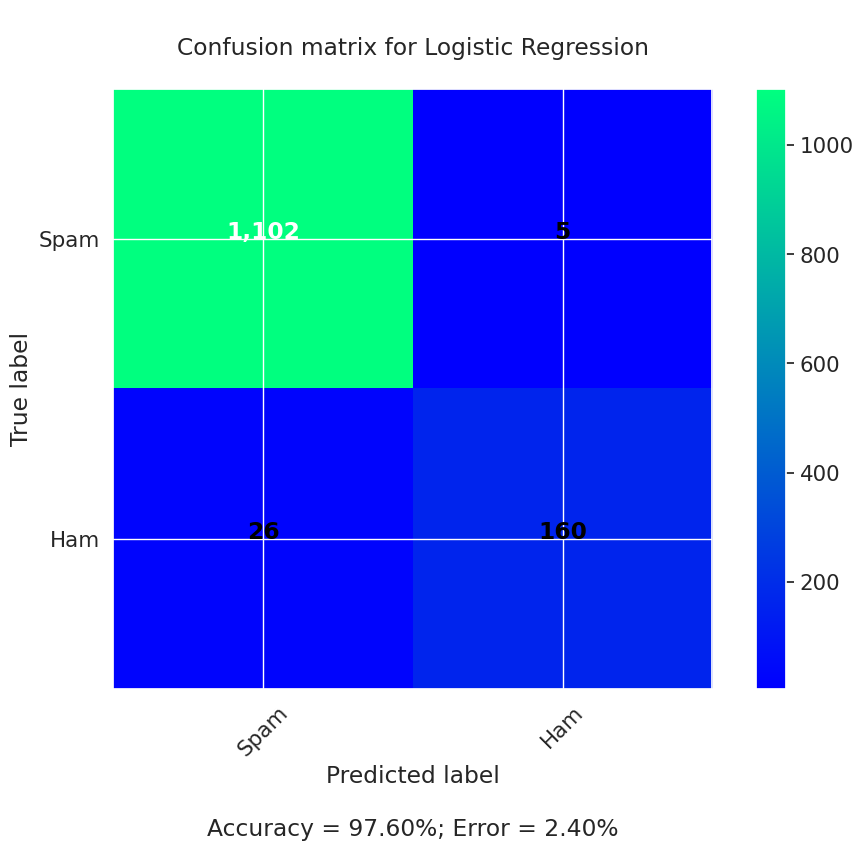

In [ ]:
print("\t\tStage IV. Logistic Regression\n")
class_LR = LogisticRegression(random_state = seed, solver = 'liblinear').fit(X_train, y_train)
y_pred_LR = class_LR.predict(X_test)
print('The first two predicted labels:', y_pred_LR[0], y_pred_LR[1], '\n')
conf_m_LR = confusion_matrix(y_test, y_pred_LR)
class_rep_LR = classification_report(y_test, y_pred_LR)
print('\t\t\tClassification report:\n\n', class_rep_LR, '\n')
plot_conf_matr(conf_m_LR, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Logistic Regression')

###  KNeighbors Classifier.


		Stage V. KNeighbors Classifier

The firs two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.95      0.99      0.97      1107
        spam       0.93      0.70      0.80       186

    accuracy                           0.95      1293
   macro avg       0.94      0.84      0.88      1293
weighted avg       0.95      0.95      0.95      1293
 



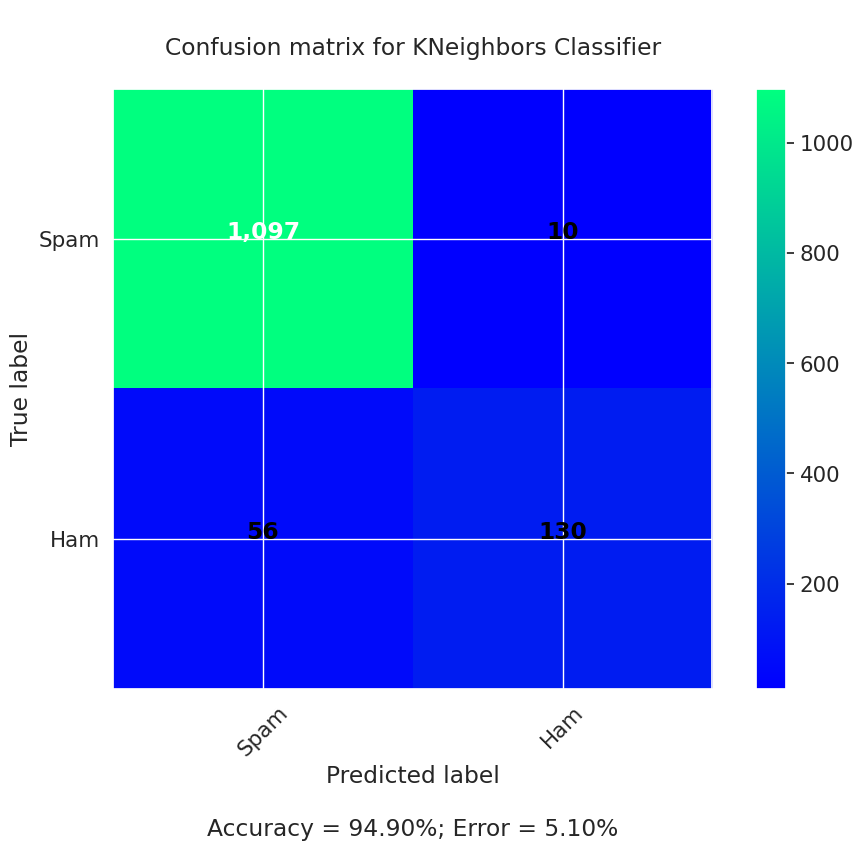

In [ ]:
print("\t\tStage V. KNeighbors Classifier\n")
class_KNC = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)
y_pred_KNC = class_KNC.predict(X_test)
print('The firs two predicted labels:', y_pred_KNC[0], y_pred_KNC[1], '\n')
conf_m_KNC = confusion_matrix(y_test, y_pred_KNC)
class_rep_KNC = classification_report(y_test, y_pred_KNC)
print('\t\t\tClassification report:\n\n', class_rep_KNC, '\n')
plot_conf_matr(conf_m_KNC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for KNeighbors Classifier')

###  Support Vector Classification.


		Stage VI. Support Vector Classification

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1107
        spam       0.98      0.86      0.91       186

    accuracy                           0.98      1293
   macro avg       0.98      0.93      0.95      1293
weighted avg       0.98      0.98      0.98      1293
 



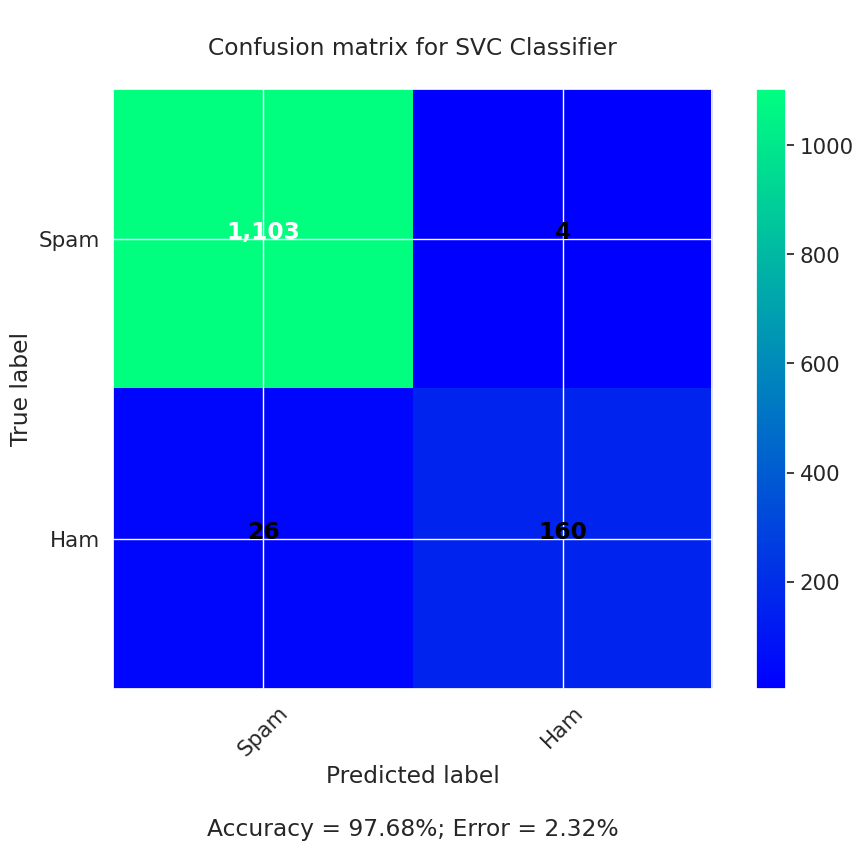

In [ ]:
print("\t\tStage VI. Support Vector Classification\n")
class_SVC = SVC(probability = True, random_state = seed).fit(X_train, y_train)
y_pred_SVC = class_SVC.predict(X_test)
print('The first two predicted labels:', y_pred_SVC[0], y_pred_SVC[1], '\n')
conf_m_SVC = confusion_matrix(y_test, y_pred_SVC)
class_rep_SVC = classification_report(y_test, y_pred_SVC)
print('\t\t\tClassification report:\n\n', class_rep_SVC, '\n')
plot_conf_matr(conf_m_SVC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for SVC Classifier')


## Gradient Boosting Classifier.


		Stage VII. Gradient Boosting Classifier

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1107
        spam       0.99      0.84      0.91       186

    accuracy                           0.98      1293
   macro avg       0.98      0.92      0.95      1293
weighted avg       0.98      0.98      0.97      1293
 



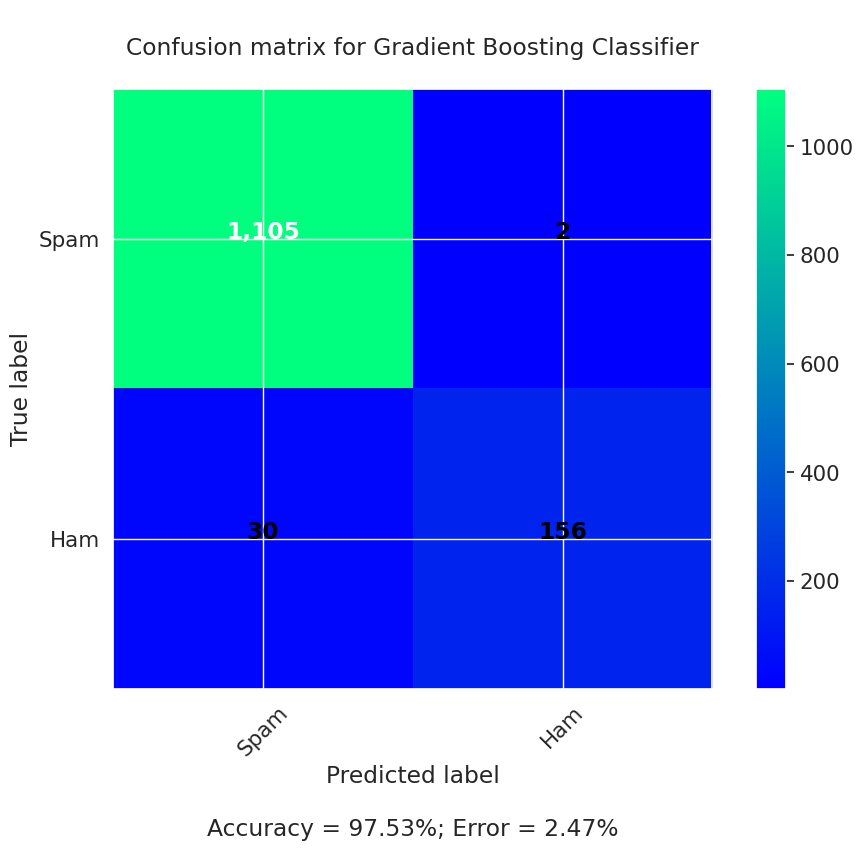

In [ ]:
print("\t\tStage VII. Gradient Boosting Classifier\n")
class_GBC = GradientBoostingClassifier(random_state = seed).fit(X_train, y_train)
y_pred_GBC = class_GBC.predict(X_test)
print('The first two predicted labels:', y_pred_GBC[0], y_pred_GBC[1], '\n')
conf_m_GBC = confusion_matrix(y_test, y_pred_GBC)
class_rep_GBC = classification_report(y_test, y_pred_GBC)
print('\t\t\tClassification report:\n\n', class_rep_GBC, '\n')
plot_conf_matr(conf_m_GBC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Gradient Boosting Classifier')

###  Bagging Classifier.


		Stage VIII. Bagging Classifier + something else

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1107
        spam       0.96      0.88      0.92       186

    accuracy                           0.98      1293
   macro avg       0.97      0.94      0.95      1293
weighted avg       0.98      0.98      0.98      1293
 



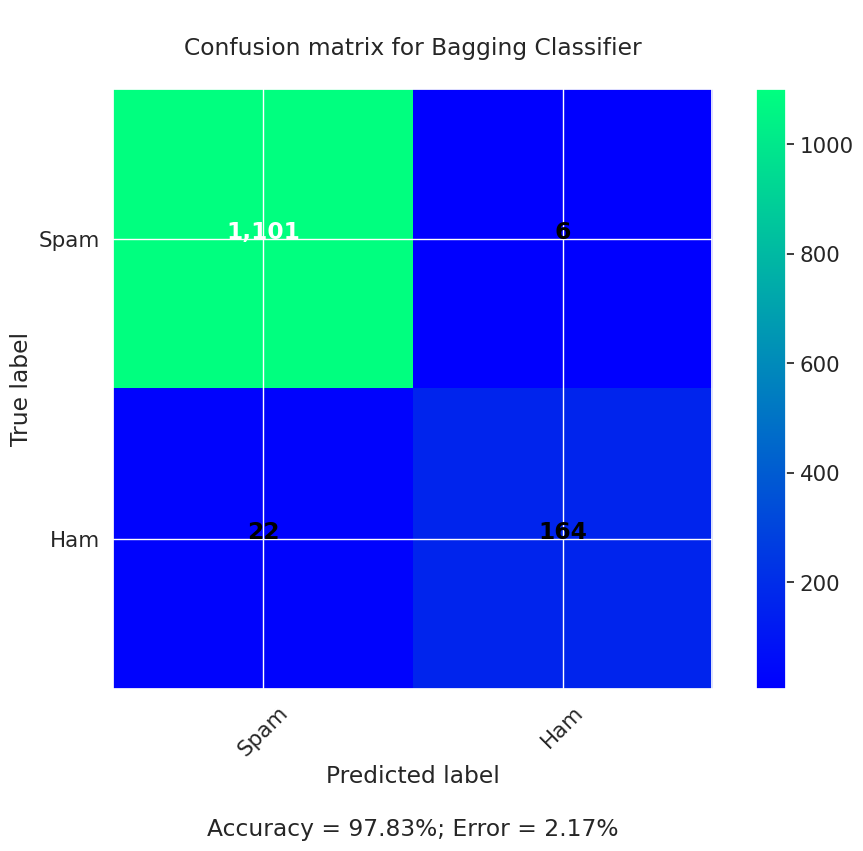

In [ ]:
print("\t\tStage VIII. Bagging Classifier + something else\n")
class_BC = BaggingClassifier(class_SVC).fit(X_train, y_train)
y_pred_BC = class_BC.predict(X_test)
print('The first two predicted labels:', y_pred_BC[0], y_pred_BC[1], '\n')
conf_m_BC = confusion_matrix(y_test, y_pred_BC)
class_rep_BC = classification_report(y_test, y_pred_BC)
print('\t\t\tClassification report:\n\n', class_rep_BC, '\n')
plot_conf_matr(conf_m_BC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Bagging Classifier')

## Deep Learning for SPAM classification task


In [ ]:
print("Stage I. Preliminary actions. Preparing of needed sets\n")

sentences_new_set = []
labels_new_set = []
for i in range(0, df.shape[0], 1):
    sentences_new_set.append(df['message'][i])
    labels_new_set.append(df['feature'][i])

Stage I. Preliminary actions. Preparing of needed sets



In [ ]:
train_size = int(df.shape[0] * (1 - test_size - valid_size))
valid_bound = int(df.shape[0] * (1 - valid_size))

train_sentences = sentences_new_set[0 : train_size]
valid_sentences = sentences_new_set[train_size : valid_bound]
test_sentences = sentences_new_set[valid_bound : ]

train_labels_str = labels_new_set[0 : train_size]
valid_labels_str = labels_new_set[train_size : valid_bound]
test_labels_str = labels_new_set[valid_bound : ]

###  Labels transformations.


In [ ]:
print("Stage II. Labels transformations\n")

train_labels = [0] * len(train_labels_str)
for ind, item in enumerate(train_labels_str):
    if item == 'ham':
        train_labels[ind] = 1
    else:
        train_labels[ind] = 0

valid_labels = [0] * len(valid_labels_str)
for ind, item in enumerate(valid_labels_str):
    if item == 'ham':
        valid_labels[ind] = 1
    else:
        valid_labels[ind] = 0

test_labels = [0] * len(test_labels_str)
for ind, item in enumerate(test_labels_str):
    if item == 'ham':
        test_labels[ind] = 1
    else:
        test_labels[ind] = 0

train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

Stage II. Labels transformations



###  Tokenization.


In [ ]:
print("Stage III. Tokenization\n")

tokenizer = Tokenizer(num_words = vocab_size,
                      oov_token = oov_token,
                      lower = False)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

Stage III. Tokenization



In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
size_voc = len(word_index) + 1
max_len = 250
train_set = pad_sequences(train_sequences,
                                padding = padding_type,
                                maxlen = max_len,
                                truncating = trunc_type)

valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
valid_set = pad_sequences(valid_sequences,
                               padding = padding_type,
                               maxlen = max_len,
                               truncating = trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_set = pad_sequences(test_sequences,
                               padding = padding_type,
                               maxlen = max_len,
                               truncating = trunc_type)

###  Model building.


In [ ]:
from tensorflow import keras


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print("Stage IV. Model building\n")
print("Stage IV. Model building\n")
model = Sequential()
model.add(Embedding(size_voc, embed_dim, input_length = max_len)),
model.add(Bidirectional(GRU(100))),
model.add(Dropout(drop_level)),
model.add(Dense(20, activation = 'relu')),
model.add(Dropout(drop_level)),
model.add(Dense(1, activation = 'sigmoid'))



Stage IV. Model building

Stage IV. Model building



###  Model compiling & fitting.


In [ ]:
print("Stage V. Model compiling & fitting\n")
optim = Adam(learning_rate = 0.0001)

model.compile(loss = 'binary_crossentropy',
              optimizer = optim,
              metrics = ['accuracy'])
model.summary()

Stage V. Model compiling & fitting

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 64)           606080    
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              99600     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 module_wrapper_2 (ModuleWra  (None, 20)               4020      
 pper)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 module_wrapper_3 

In [ ]:
history = model.fit(train_set,
                    train_labels,
                    epochs = 20,
                    validation_data = (valid_set, valid_labels),
                    workers = os.cpu_count(),
                    use_multiprocessing = True,
                    verbose = 1)

Epoch 1/20
122/122 [==============================] - 27s 155ms/step - loss: 0.5616 - accuracy: 0.8452 - val_loss: 0.3532 - val_accuracy: 0.8803
Epoch 2/20
122/122 [==============================] - 7s 57ms/step - loss: 0.3362 - accuracy: 0.8697 - val_loss: 0.2673 - val_accuracy: 0.8803
Epoch 3/20
122/122 [==============================] - 5s 37ms/step - loss: 0.2360 - accuracy: 0.8787 - val_loss: 0.2078 - val_accuracy: 0.9151
Epoch 4/20
122/122 [==============================] - 3s 28ms/step - loss: 0.1767 - accuracy: 0.9481 - val_loss: 0.1733 - val_accuracy: 0.9305
Epoch 5/20
122/122 [==============================] - 5s 40ms/step - loss: 0.1388 - accuracy: 0.9610 - val_loss: 0.1368 - val_accuracy: 0.9459
Epoch 6/20
122/122 [==============================] - 3s 26ms/step - loss: 0.1060 - accuracy: 0.9685 - val_loss: 0.1065 - val_accuracy: 0.9614
Epoch 7/20
122/122 [==============================] - 4s 35ms/step - loss: 0.0790 - accuracy: 0.9770 - val_loss: 0.1062 - val_accuracy: 0.96

### VI stage. Results visualization.


In [ ]:
model_score = model.evaluate(test_set, test_labels, batch_size = embed_dim, verbose = 1)
print(f"Test accuracy: {model_score[1] * 100:0.2f}% \t\t Test error: {model_score[0]:0.4f}")

17/17 [==============================] - 0s 18ms/step - loss: 0.0612 - accuracy: 0.9874
Test accuracy: 98.74% 		 Test error: 0.0612


### VII stage. Model saving & predict checking.


33/33 [==============================] - 1s 12ms/step
			Classification report:

               precision    recall  f1-score   support

           0       0.95      0.94      0.94       117
           1       0.99      0.99      0.99       917

    accuracy                           0.99      1034
   macro avg       0.97      0.97      0.97      1034
weighted avg       0.99      0.99      0.99      1034
 



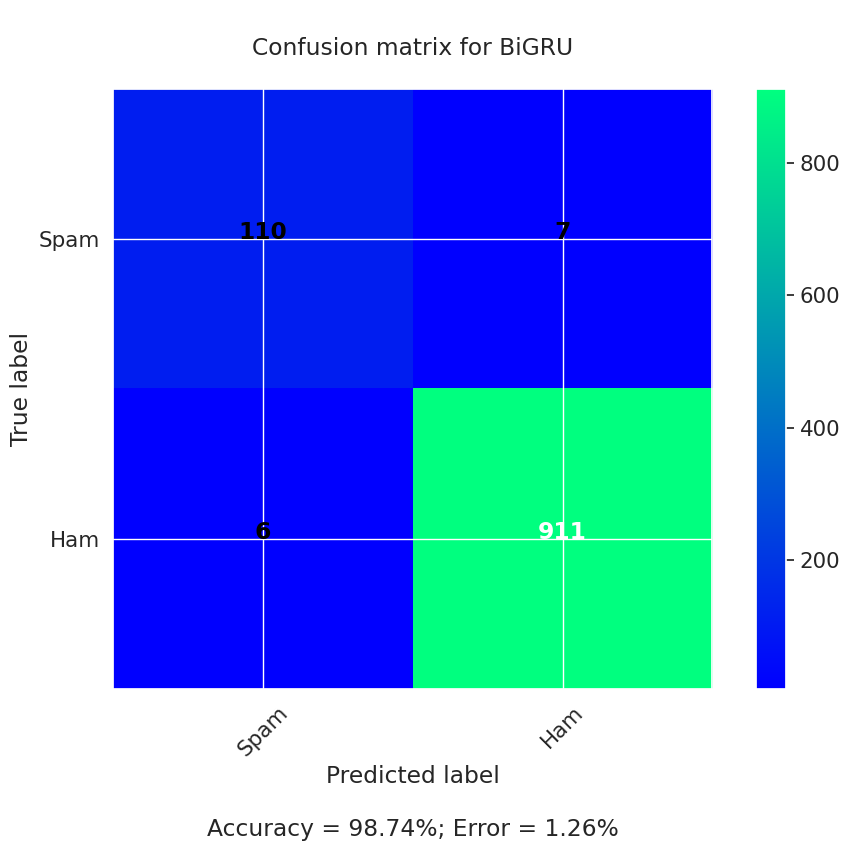

In [ ]:
y_pred= model.predict(test_set)

y_prediction = [0] * y_pred.shape[0]
for ind, item in enumerate(y_pred):
    if item > threshold:
        y_prediction[ind] = 1
    else:
        y_prediction[ind] = 0

conf_m = confusion_matrix(test_labels, y_prediction)
class_rep = classification_report(test_labels, y_prediction)
print('\t\t\tClassification report:\n\n', class_rep, '\n')
plot_conf_matr(conf_m, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for BiGRU')

In [ ]:
message_example = ["Darling, please give me a cup of tea"]

message_example_tp = pad_sequences(tokenizer.texts_to_sequences(message_example),
                                   maxlen = max_len,
                                   padding = padding_type,
                                   truncating = trunc_type)

pred = float(model.predict(message_example_tp))
if (pred > threshold):
    print ("This message is a real text")
else:
    print("This message is a spam message")

1/1 [==============================] - 0s 26ms/step
This message is a real text
